### Import Library and Global Variable

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import copy
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
# loading json file
import json
import argparse
from torch.autograd import Variable

idx_size = 26 + 2 # 26 lower-case char + SOS + EOS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Preprocess
1. Encode string to indices or indices to string
2. Read JSON file and save into pair string or pair indices 

In [2]:
class Data_Encoder():
    def __init__(self) -> None:
        # no need for UNKnown 
        # because our data only have english lower-case 
        self.char_to_idx = {'SOS': 0, 'EOS': 1} 
        self.char_to_idx.update([(chr(i + 97),i + 2) for i in range(0, 26)])
        self.idx_to_char = {0: 'SOS', 1: 'EOS'}
        self.idx_to_char.update([(i + 2, chr(i + 97)) for i in range(0,26)])
        self.max_training_word = 0

    def str_to_indices(self, str_, add_sos=False, add_eos=False):
        indices = [self.char_to_idx['SOS']] if add_sos else []
        indices += [self.char_to_idx[char] for char in str_]
        if add_eos:
            indices += [self.char_to_idx['EOS']]
        self.max_training_word = max(self.max_training_word, len(indices))
        return indices

    def indices_to_str(self, indices):
        return ''.join(self.idx_to_char[idx] for idx in indices)


In [3]:
def read_json_to_pairs(file_path):
    data_pairs = []
    with open(file_path, 'r') as json_file:
        data_list = json.load(json_file)
        for item in data_list:
            input, target = item['input'], item['target']
            data_pairs += [[input[i], target] for i in range(len(input))]   
    
    return data_pairs     

def data_to_indices(data_pairs):
    indices_pairs = []
    d_en = Data_Encoder()
    for pair in data_pairs:
        indices_pairs += [[d_en.str_to_indices(pair[0], add_eos=True), d_en.str_to_indices(pair[1], add_eos=True)]]
    
    return indices_pairs


### RNN Encoder

In [4]:
class RNN_Encoder(nn.Module):
    # args = [input_size, embedding_size, hidden_size]
    def __init__(self, args):
        super().__init__()
        self.hidden_size = args[2]
        self.embedding = nn.Embedding(args[0], args[1])
        self.lstm = nn.LSTM(args[1], args[2])
        
    def forward(self, input, hidden_state, cell_state):
        output = self.embedding(input).view(1, 1, -1)
        output, (hidden_state, cell_state) = self.lstm(output, (hidden_state, cell_state))
        
        return output, hidden_state, cell_state

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def init_cell(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### RNN Decoder

In [5]:
class RNN_Decoder(nn.Module):
    # args = [input_size, embedding_size, hidden_size]
    def __init__(self, args):
        super().__init__()
        self.hidden_size = args[2]
        self.embedding = nn.Embedding(args[0], args[1])
        self.lstm = nn.LSTM(args[1], args[2])
        self.linear = nn.Linear(args[2], args[0])
        self.activation = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden_state, cell_state):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, (hidden_state,cell_state) = self.lstm(output, (hidden_state,cell_state) )
        output = self.activation(self.linear(output[0]))
        return output, hidden_state, cell_state

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def init_cell(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)   

### Compute BLEU

In [6]:
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output, weights=weights, smoothing_function=cc.method1)

### Training and Testing Model

In [7]:
def train(model, data, opts):
    loss_total = 0
    random.shuffle(data)
    encoder_optimizer = opts.optimizer(model['encoder'].parameters(), lr=opts.learning_rate)
    decoder_optimizer = opts.optimizer(model['decoder'].parameters(), lr=opts.learning_rate)
    
    for input_tensor, target_tensor in data:
        loss = 0

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        encoder_outputs = torch.zeros(idx_size, opts.hidden_size, device=device)
        # encoder
        encoder_hidden = model['encoder'].init_hidden()
        encoder_cell = model['encoder'].init_cell()
        for e_idx in range(input_tensor.size(0)):
            output, encoder_hidden, encoder_cell = model['encoder'](input_tensor[e_idx], encoder_hidden, encoder_cell)
            encoder_outputs[e_idx] = output[0,0]
        
        # decoder
        decoder_input = torch.tensor([[0]], device=device)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        Teacher_force = True if random.random() < opts.teacher_forcing_ratio else False
        for d_idx in range(target_tensor.size(0)):
            output, decoder_hidden, decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
            loss += opts.loss_function(output, target_tensor[d_idx])
            # use teacher force to choose input
            if Teacher_force:
                # using 
                decoder_input = target_tensor[d_idx]
            else:
                _, topi = output.topk(1)
                decoder_input = topi.squeeze().detach()
                if decoder_input.item() == 1:
                    break
                
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_total += loss.item()/target_tensor.size(0)

    return loss_total/len(data)

def test(model, data, opts):
    predicted_list = []
    for input_tensor, _ in data:
        predicted = []
        encoder_outputs = torch.zeros(idx_size, opts.hidden_size, device=device)
        encoder_hidden = model['encoder'].init_hidden()
        encoder_cell = model['encoder'].init_cell()
        for e_idx in range(input_tensor.size(0)):
            output, encoder_hidden, encoder_cell = model['encoder'](input_tensor[e_idx], encoder_hidden, encoder_cell)
            encoder_outputs[e_idx] = output[0,0]    

        decoder_input = torch.tensor([[0]],device=device)
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        for _ in range(idx_size):
            output, decoder_hidden, decoder_cell = decoder(decoder_input,decoder_hidden,decoder_cell)
            _, topi = output.data.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == 1:
                break
            else: 
                predicted.append(decoder_input.item())

        predicted_list += [predicted]

    return predicted_list

### Plot Result

In [8]:
def plot(loss, bleu):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Loss')
    plt.plot(bleu, label='BLEU')
    plt.legend()
    plt.show()
    return fig

### Main Function

train.json + test.json

epoch 1 loss:1.8898
input:  contenpted
target: contented
pred:   conttented
input:  begining
target: beginning
pred:   banging
input:  problam
target: problem
pred:   problamoe
input:  dirven
target: driven
pred:   divener
input:  ecstacy
target: ecstasy
pred:   eactascy
input:  juce
target: juice
pred:   juce
input:  localy
target: locally
pred:   tolly
input:  compair
target: compare
pred:   compira
input:  pronounciation
target: pronunciation
pred:   proosiionionns
input:  transportibility
target: transportability
pred:   tritoritoiblestsly
input:  miniscule
target: minuscule
pred:   misuilins
input:  independant
target: independent
pred:   innnnniinn
input:  aranged
target: arranged
pred:   agrannd
input:  poartry
target: poetry
pred:   porraary
input:  leval
target: level
pred:   live
input:  basicaly
target: basically
pred:   basaily
input:  triangulaur
target: triangular
pred:   truarrannar
input:  unexpcted
target: unexpected
pred:   untoredd
input:  stanerdizing
target: standa

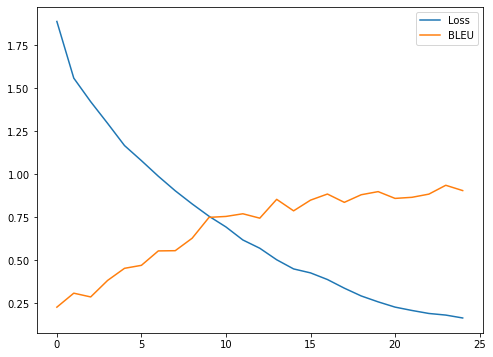

In [9]:
if __name__=='__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--epoch', type=int, default=25, help='Default epoches is 50')
    parser.add_argument('--loss_function', type=type, default=nn.CrossEntropyLoss(), help='Default loss function is CrossEntropyLoss')
    parser.add_argument('--hidden_size', type=int, default=512, help='Default LSTM hidden size is 256')
    parser.add_argument('--embedding_size', type=int, default=512, help='Default LSTM hidden size is 256')
    parser.add_argument('--learning_rate', type=float, default=5e-2, help='Default learning rate is 1e-2')
    parser.add_argument('--optimizer', type=type, default=optim.SGD, help='Default optimizer is SGD')
    parser.add_argument('--teacher_forcing_ratio', type=float, default=0.5, help='Default teacher forcing ratio is 0.5')

    opts = parser.parse_args([])

    train_data_pairs = read_json_to_pairs(file_path='train.json')
    test_data_pairs = read_json_to_pairs(file_path='test.json')

    train_idx_pairs = data_to_indices(train_data_pairs)
    test_idx_pairs = data_to_indices(test_data_pairs)

    train_input = []
    for idx_pair in train_idx_pairs:
        feature = torch.tensor(idx_pair[0], device=device).view(-1, 1)
        target = torch.tensor(idx_pair[1], device=device).view(-1, 1)
        train_input += [[feature, target]]

    test_input = []
    for idx_pair in test_idx_pairs:
        feature = torch.tensor(idx_pair[0], device=device).view(-1, 1)
        target = torch.tensor(idx_pair[1], device=device).view(-1, 1)
        test_input += [[feature, target]]

    # spend time 19.1s #
    
    ###################
    # call LSTM model #
    ###################
    
    encoder = RNN_Encoder([idx_size, opts.embedding_size, opts.hidden_size]).to(device)
    decoder = RNN_Decoder([idx_size, opts.embedding_size, opts.hidden_size]).to(device)
    
    ##############
    # Train/Test #
    ##############
    model = {'encoder': encoder, 'decoder': decoder}
    
    loss_list = []
    BLEU_list = []
    best_score = 0
    best_encoder_wts, best_decoder_wts = None, None

    for epoch in range(1, opts.epoch + 1):
        loss = train(model, train_input, opts)
        print(f'epoch{epoch:>2d} loss:{loss:.4f}')
        predict_list = test(model, test_input, opts)
        score = 0
        for i, (input, target) in enumerate(test_data_pairs):
            predict = Data_Encoder().indices_to_str(predict_list[i])
            print(f'input:  {input}')
            print(f'target: {target}')
            print(f'pred:   {predict}')
            print('============================')
            score += compute_bleu(predict, target)

        score /= len(test_data_pairs)
        print(f'BLEU-4 score: {score:.4f}')

        loss_list.append(loss)
        BLEU_list.append(score)
 
    # plot
    figure = plot(loss_list, BLEU_list)
    figure.savefig(os.path.join('result', f'teacher{opts.teacher_forcing_ratio:.2f}_hidden{opts.hidden_size}.png'))


train.json + new_test.json

epoch 1 loss:1.8681
input:  apreciate
target: appreciate
pred:   apritiait
input:  appeciate
target: appreciate
pred:   apparitii
input:  apprciate
target: appreciate
pred:   apparitia
input:  apprecate
target: appreciate
pred:   apparatite
input:  apprecite
target: appreciate
pred:   appritiit
input:  luve
target: love
pred:   leve
input:  culd
target: cold
pred:   culle
input:  heart
target: heart
pred:   hear
input:  televiseon
target: television
pred:   teleles
input:  thone
target: phone
pred:   thone
input:  phace
target: phase
pred:   pharce
input:  poam
target: poem
pred:   poma
input:  tomorraw
target: tomorrow
pred:   torrmmar
input:  presishan
target: precision
pred:   prasiin
input:  presishion
target: precision
pred:   priiisiin
input:  presisian
target: precision
pred:   priiiis
input:  presistion
target: precision
pred:   prisiiits
input:  perver
target: prefer
pred:   priver
input:  predgudice
target: prejudice
pred:   proughid
input:  predgudis
target: prejudice
pred: 

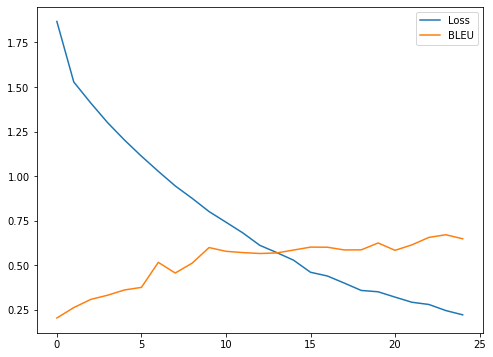

In [9]:
if __name__=='__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--epoch', type=int, default=25, help='Default epoches is 50')
    parser.add_argument('--loss_function', type=type, default=nn.CrossEntropyLoss(), help='Default loss function is CrossEntropyLoss')
    parser.add_argument('--hidden_size', type=int, default=512, help='Default LSTM hidden size is 256')
    parser.add_argument('--embedding_size', type=int, default=512, help='Default LSTM hidden size is 256')
    parser.add_argument('--learning_rate', type=float, default=5e-2, help='Default learning rate is 1e-2')
    parser.add_argument('--optimizer', type=type, default=optim.SGD, help='Default optimizer is SGD')
    parser.add_argument('--teacher_forcing_ratio', type=float, default=0.8, help='Default teacher forcing ratio is 0.5')

    opts = parser.parse_args([])

    train_data_pairs = read_json_to_pairs(file_path='train.json')
    test_data_pairs = read_json_to_pairs(file_path='new_test.json')

    train_idx_pairs = data_to_indices(train_data_pairs)
    test_idx_pairs = data_to_indices(test_data_pairs)

    train_input = []
    for idx_pair in train_idx_pairs:
        feature = torch.tensor(idx_pair[0], device=device).view(-1, 1)
        target = torch.tensor(idx_pair[1], device=device).view(-1, 1)
        train_input += [[feature, target]]

    test_input = []
    for idx_pair in test_idx_pairs:
        feature = torch.tensor(idx_pair[0], device=device).view(-1, 1)
        target = torch.tensor(idx_pair[1], device=device).view(-1, 1)
        test_input += [[feature, target]]

    # spend time 19.1s #
    
    ###################
    # call LSTM model #
    ###################
    
    encoder = RNN_Encoder([idx_size, opts.embedding_size, opts.hidden_size]).to(device)
    decoder = RNN_Decoder([idx_size, opts.embedding_size, opts.hidden_size]).to(device)
    
    ##############
    # Train/Test #
    ##############
    model = {'encoder': encoder, 'decoder': decoder}
    
    loss_list = []
    BLEU_list = []
    best_score = 0
    best_encoder_wts, best_decoder_wts = None, None

    for epoch in range(1, opts.epoch + 1):
        loss = train(model, train_input, opts)
        print(f'epoch{epoch:>2d} loss:{loss:.4f}')
        predict_list = test(model, test_input, opts)
        score = 0
        for i, (input, target) in enumerate(test_data_pairs):
            predict = Data_Encoder().indices_to_str(predict_list[i])
            print(f'input:  {input}')
            print(f'target: {target}')
            print(f'pred:   {predict}')
            print('============================')
            score += compute_bleu(predict, target)

        score /= len(test_data_pairs)
        print(f'BLEU-4 score: {score:.4f}')

        loss_list.append(loss)
        BLEU_list.append(score)
        
    # plot
    figure = plot(loss_list, BLEU_list)
    figure.savefig(os.path.join('result', f'teacher{opts.teacher_forcing_ratio:.2f}_hidden{opts.hidden_size}.png'))


### Report


```python
Procedures:
    1. Data Preprocess
        Read JSON to pairs: 將json檔讀入，並將資料型態轉成[input_string,  target_string]的樣子
        ex: ["apreciate", "appreciate"]
        Pairs to indices: 將上面的資料內的每個字串利用我們的Data Encoder轉換成indices
        ex: [[2, 17, 19, 6, 4, 10, 2, 21, 6], [2, 17, 17, 19, 6, 4, 10, 2, 21, 6]]

    2. LSTM model
        Encoder:
        RNN_Encoder(
            (embedding): Embedding(28, 512)
            (lstm): LSTM(512, 512)
        )

        Decoder:
        RNN_Decoder(
            (embedding): Embedding(28, 512)
            (lstm): LSTM(512, 512)
            (linear): Linear(in_features=512, out_features=28, bias=True)
            (activation): LogSoftmax(dim=1)
        )
    3. Training and Testing
        Training:
            Encoder: 將input字母，初始hidden state和cell state傳入我們的LSTM encoder，計算新的hidden state和cell state，不斷重複直到所有字母傳入。
            
            Decoder: 將target字母或是上一輪的output(此處根據teacher_force隨機選擇，teacher_force越接近1則選擇target的機率越高)和encoder跑完的hidden state和cell state傳入我們的LSTM decoder，計算新的hidden state和cell state，不斷重複直到所有字母傳入。
        
        Testing:
            Encoder: 將input字母，初始hidden state和cell state傳入我們的LSTM encoder，計算新的hidden state和cell state，不斷重複直到所有字母傳入。

            Decoder: 將上一輪的output和encoder跑完的hidden state和cell state傳入我們的LSTM decoder，計算新的hidden state和cell state，不斷重複直到所有字母傳入


Discussions:
    1. train.json + test.json: 本次實驗我有用不同hidden size去實驗，我嘗試了256和512的結果，發現他們在分別在第15個epoch第9個epoch都可以達到BLEU-4 score 0.8 以上，然後最後的結果都可以達到0.9以上，但256跑的速度相比512快了許多。除此之外我也調整了teacher force去對模型進行調整，發現結果皆能在25個epoch左右達到BLEU-4 score 0.9 以上。
    
    2. train.json + new_test.json: new_test的結果相比，test遜色很多，我也嘗試了用不同hidden size去實驗，結果他都在0.6左右就開始收斂，loss會不斷下降，但acc上升不了太多，可能是因為我沒去做dropout來降低overfitting或是我的teacher force設定的不夠高。
    
```